<a href="https://colab.research.google.com/github/109368018yumin/project/blob/main/Remove_RF_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#########remove outliers###########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive 

drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/dissertation/UIC_data/output/
df_all = pd.read_csv("NORMAL_BLOOD_PRESSURE2.csv") 

num_features = ['PPG_DBP_Time_plus_PPG_Amplitude_time', 'PTT', 'PPG_DBP_Time_divide_PTT','PPG_one_wave_time', 'PPG_DBP_Time','PPG_Amplitude_time','PTT_DBP_percent']
target = ['SBP','DBP']

df = df_all[num_features + target]
df.head()
df.describe()

sus = ['PPG_DBP_Time_plus_PPG_Amplitude_time', 'PTT', 'PPG_DBP_Time_divide_PTT','PPG_one_wave_time', 'PPG_DBP_Time','PPG_Amplitude_time','PTT_DBP_percent']
remove = set()

#indices = set()
for x in sus:
  q25, q75 = np.percentile(df.loc[:,x], [25, 75])
  n=1.5#1.5倍四分位距
  #IQR=Q3-Q1
  intra = q75 - q25
  # outlier = Q3 + n*IQR 
  max = q75 + intra *n
  # outlier = Q1 - n*IQR 
  min = q25 - intra *n
  
  transform_data1 = df.loc[df[x] < min, x].index
  transform_data2 = df.loc[df[x] > max, x].index
  remove = remove.union(transform_data1).union(transform_data2)
  
df.drop(remove, inplace=True)
df.to_csv('removed_data.csv')
#########remove outliers###########

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/dissertation/UIC_data/output


In [6]:
!pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10669 sha256=1b103b477670242a2543d4656ac8530b8986380cca3f27bf87c4a63a44812cd4
  Stored in directory: /root/.cache/pip/wheels/ad/48/d9/21fc62fbeff405425b0d5dd8b0354576cdb62ac97f6b11d1ef
Successfully built rfpimp


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


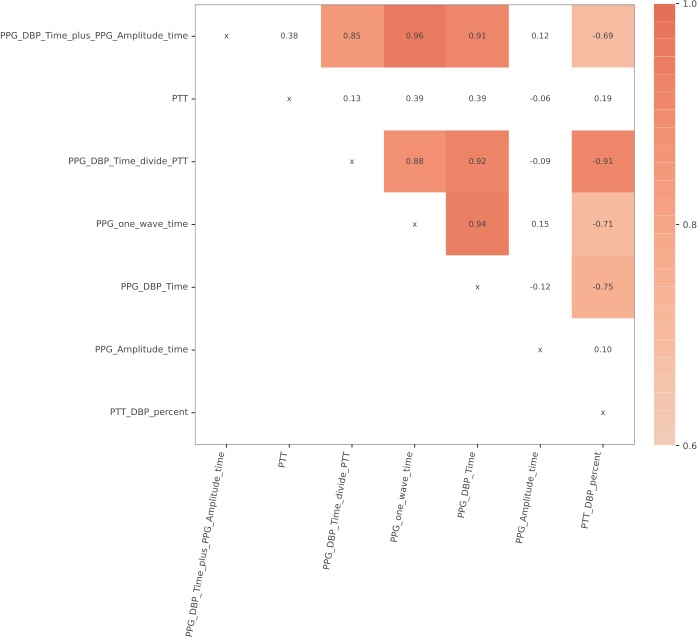

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_all = pd.read_csv("removed_data.csv") 

num_features = ['PPG_DBP_Time_plus_PPG_Amplitude_time', 'PTT', 'PPG_DBP_Time_divide_PTT','PPG_one_wave_time', 'PPG_DBP_Time','PPG_Amplitude_time','PTT_DBP_percent']
target = ['SBP','DBP']

df = df_all[num_features + target]
df.head()

df.describe()

df_target = pd.DataFrame(df, columns=["SBP", "DBP"])
df.drop(["SBP", "DBP"], axis=1, inplace=True)
df_target.head()

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
folds = KFold(n_splits=10, shuffle=True)

# resplit the data after processing
x_train, x_test, y_train, y_test = train_test_split(df, df_target, test_size=0.3)

from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(x_train,figsize=(10,10))
viz


MAE SBP: 2.1607513704024415 SD:3.2267856414069005 MAE DBP: 1.1523538015086725 SD:13.991087198534506


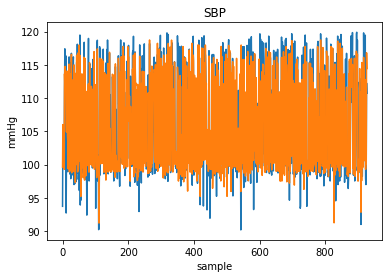

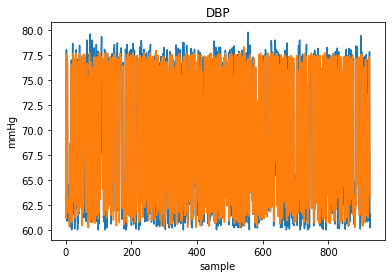

In [15]:
#####RandomForest Regressor#######
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
regressor = RandomForestRegressor(n_estimators = 100) 
regressor.fit(x_train, y_train)
prediction = regressor.predict(x_test)

error_sbp = mean_absolute_error(prediction[:,0],y_test["SBP"].values)
error_dbp = mean_absolute_error(prediction[:,1],y_test["DBP"].values)

error_sbp_std = np.std(prediction[:,0] - y_test["SBP"].values)
error_dbp_std = np.std(prediction[:,1] - y_test["SBP"].values)

print(f"MAE SBP: {error_sbp} SD:{error_sbp_std} MAE DBP: {error_dbp} SD:{error_dbp_std}")

s = np.vstack(y_test["SBP"])
d = np.vstack(y_test["DBP"])

plt.figure(1)
plt.title("SBP")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(s)
plt.plot(prediction[:,0])

plt.figure(2)
plt.title("DBP")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(d)
plt.plot(prediction[:,1])

MAE SBP: 3.3232011933047216 SD:4.494196274087422 MAE DBP: 4.150710276336451 SD:5.036977828324882


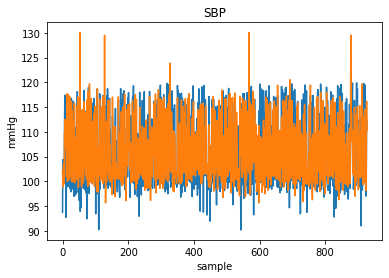

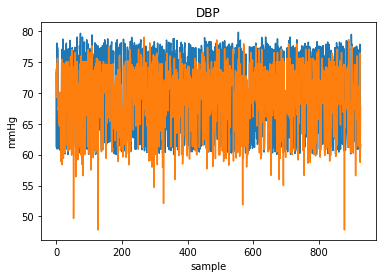

In [16]:
##############Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

linear = LinearRegression()
linear.fit(x_train, y_train)
prediction = linear.predict(x_test)

error_sbp = mean_absolute_error(prediction[:,0],y_test["SBP"].values)
error_dbp = mean_absolute_error(prediction[:,1],y_test["DBP"].values)

error_sbp_std = np.std(prediction[:,0] - y_test["SBP"].values)
error_dbp_std = np.std(prediction[:,1] - y_test["DBP"].values)

print(f"MAE SBP: {error_sbp} SD:{error_sbp_std} MAE DBP: {error_dbp} SD:{error_dbp_std}")

s = np.vstack(y_test["SBP"])
d = np.vstack(y_test["DBP"])

plt.figure(1)
plt.title("SBP")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(s)
plt.plot(prediction[:,0])

plt.figure(2)
plt.title("DBP")
plt.xlabel("sample") 
plt.ylabel("mmHg") 
plt.plot(d)
plt.plot(prediction[:,1])